# QC and concatenation of cellranger-arc mapping using Muon

[GEX-Data](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-12916/sdrf?full=true) 

[ATAC-DATA](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-12919/sdrf?full=true)

    
    Developed by: Christian Eger
    Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
    Created on: 240613
    Last modified: 240613

## Import modules

In [1]:
import os 
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import muon as mu
from muon import atac as ac

/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:


def plot_parameter_summary(summary_paths: list, metric):
    """
    Extracts the data for the given metric from summary files.
    
    Parameters:
    - summary_paths: List of paths to summary CSV files.
    - metric: The metric to extract the data for.
    
    Returns:
    - List of metric values as floats.
    """
    summary_dict = {metric: []}
    for summary in summary_paths:
        summary_df = pd.read_csv(summary)
        # Convert the metric values to float and handle non-numeric values
        value = pd.to_numeric(summary_df[metric][0], errors='coerce')
        summary_dict[metric].append(value)
    return summary_dict[metric]

def plot_histograms(summary_paths, metrics, bins=10, figsize=(50, 30)):
    """
    Plots histograms for an arbitrary number of metrics in a grid, with a red line at the mean.
    
    Parameters:
    - summary_paths: List of paths to summary CSV files.
    - metrics: List of metrics to plot histograms for.
    - bins: Number of bins for the histograms (default is 10).
    """
    num_histograms = len(metrics)
    
    # Determine the number of rows and columns for the grid
    cols = math.ceil(math.sqrt(num_histograms))
    rows = math.ceil(num_histograms / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i, metric in enumerate(metrics):
        data = plot_parameter_summary(summary_paths, metric)
        data = [d for d in data if not np.isnan(d)]  # Filter out NaN values
        mean_value = np.mean(data)
        axes[i].hist(data, bins=bins)
        axes[i].axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'{metric} (Mean: {mean_value:.2f})')
    
    # Remove any unused axes
    for i in range(num_histograms, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()



## Directories

In [3]:
parent_dir = '../../../../backup/.data/'
mapping_dir = os.path.join(parent_dir, 'mapping_py')
meta_data_dir = os.path.join(parent_dir, 'meta_data')
meta_data = pd.read_csv(os.path.join(meta_data_dir, 'downloads_table.csv'), index_col=0, header=None)
samples = pd.read_csv(os.path.join(meta_data_dir, 'downloads_table.csv'), index_col=0, header=None).index.unique()
mapping_h5 = {sample: os.path.join(mapping_dir, sample, sample, 'outs/filtered_feature_bc_matrix.h5') for sample in samples if os.path.isfile(os.path.join(mapping_dir, sample, sample, 'outs/filtered_feature_bc_matrix.h5'))}
mapping_summaries = [os.path.join(mapping_dir, sample, sample, 'outs/summary.csv') for sample in samples if os.path.isfile(os.path.join(mapping_dir, sample, sample, 'outs/summary.csv'))]
failed_mappings = [sample for sample in samples if not os.path.isdir(os.path.join(mapping_dir, sample, sample, 'outs'))]

In [4]:
failed_mappings

['HCAHeartST11350194_HCAHeartST11445771']

## Quality Assessment

In [5]:
metrics = pd.read_csv(mapping_summaries[0]).columns.tolist()
metrics

['Sample ID',
 'Genome',
 'Pipeline version',
 'Estimated number of cells',
 'Feature linkages detected',
 'Linked genes',
 'Linked peaks',
 'ATAC Confidently mapped read pairs',
 'ATAC Fraction of genome in peaks',
 'ATAC Fraction of high-quality fragments in cells',
 'ATAC Fraction of high-quality fragments overlapping TSS',
 'ATAC Fraction of high-quality fragments overlapping peaks',
 'ATAC Fraction of transposition events in peaks in cells',
 'ATAC Mean raw read pairs per cell',
 'ATAC Median high-quality fragments per cell',
 'ATAC Non-nuclear read pairs',
 'ATAC Number of peaks',
 'ATAC Percent duplicates',
 'ATAC Q30 bases in barcode',
 'ATAC Q30 bases in read 1',
 'ATAC Q30 bases in read 2',
 'ATAC Q30 bases in sample index i1',
 'ATAC Sequenced read pairs',
 'ATAC TSS enrichment score',
 'ATAC Unmapped read pairs',
 'ATAC Valid barcodes',
 'GEX Fraction of transcriptomic reads in cells',
 'GEX Mean raw reads per cell',
 'GEX Median UMI counts per cell',
 'GEX Median genes per

### Multiome Metrics Definitions
Metric|Description
-|-
Estimated number of cells| The number of barcodes associated with cell-containing partitions.
Feature linkages detected| Total number of gene-to-peak and peak-to-peak linkages detected.
Linked genes| Total number of genes that are linked to peaks.
Linked peaks| Total number of peaks that are linked to genes or other peaks.

### Chromatin accessibility metrics definitions
Metrics in this table have ATAC prefix in the pipeline output.
Metric|Description
-|-
Confidently mapped read pairs|	Fraction of sequenced read pairs with mapping quality > 30.
Fraction of genome in peaks|	Fraction of bases in primary contigs (contigs containing genes) that are defined as peaks.
Fraction of high-quality fragments in cells	|Fraction of high-quality fragments with a valid barcode that are associated with cell-containing partitions. High-quality fragments are defined as read pairs with a valid barcode that map to the nuclear genome with mapping quality > 30, are not chimeric and not duplicate.
Fraction of high-quality fragments overlapping peaks|	Fraction of high-quality fragments in cell barcodes that overlap called peaks.
Fraction of high-quality fragments overlapping TSS	|Fraction of high-quality fragments in cell barcodes that overlap transcription start sites (TSS).
Fraction of transposition events in peaks in cells	|Fraction of transposition events that are associated with cell-containing partitions and fall within peaks. Transposition events are located at both ends of all high-quality fragments. This metric measures the percentage of such events that overlap with peaks.
Mean raw read pairs per cell	|Total number of read pairs divided by the number of cell barcodes.
Median high-quality fragments per cell	|The median number of high-quality fragments per cell barcode.
Non-nuclear read pairs	|Fraction of sequenced read pairs that have a valid barcode and map to non-nuclear genome contigs, including mitochondria, with mapping quality > 30.
Number of peaks	Total |number of peaks on primary contigs either detected by the pipeline or input by the user.
Percent duplicates	|Fraction of high-quality read pairs that are deemed to be PCR duplicates. This metric is a measure of sequencing saturation and is a function of library complexity and sequencing depth. More specifically, this is the fraction of high-quality fragments with a valid barcode that align to the same genomic position as another read pair in the library.
Q30 bases in barcode	|Fraction of barcode read (i5 index read) bases with Q-score ≥ 30.
Q30 bases in read 1	|Fraction of read 1 bases with Q-score ≥ 30.
Q30 bases in read 2	|Fraction of read 2 bases with Q-score ≥ 30.
Q30 bases in sample index i1	|Fraction of sample index read (i7 index read) bases with Q-score ≥ 30.
Sequenced read pairs	|Total number of sequenced read pairs assigned to the sample.
TSS enrichment score	|Maximum value of the transcription-start-site (TSS) profile.The TSS profile is the summed accessibility signal (defined as number of cut sites per base) in a window of 2,000 bases around all the annotated TSSs, normalized by the minimum signal in the window.
Unmapped read pairs	|Fraction of sequenced read pairs that have a valid barcode but could not be mapped to the genome.

### Gene Expression metrics definitions
Metrics in this table have GEX prefix in the pipeline output.
Metric	|Description
-|-
Fraction of transcriptomic reads in cells|	Fraction of transcriptomic reads with a valid barcode that are associated with cell-containing partitions. Transcriptomic reads are defined as reads with mapping quality = 255 that map to a unique gene, including intronic alignments (default mode). When excluding introns the transcriptome is restricted to alignments that are consistent with annotated splice junctions. Note that transcriptomic reads include UMI reads, duplicate reads, and reads marked as low-support molecules.
Mean raw reads per cell|	Total number of reads divided by the number of cell barcodes.
Median genes per cell|	The median number of genes detected per cell barcode. Detection is defined as the presence of at least one UMI count.
Median UMI counts per cell|	The median number of UMI counts per cell barcode.
Percent duplicates|	The fraction of reads originating from an already-observed UMI. This is a function of library complexity and sequencing depth. More specifically, this is the fraction of confidently mapped, valid barcode, valid UMI reads that have a non-unique (barcode, UMI, gene).
Q30 bases in barcode|	Fraction of barcode bases with Q-score ≥ 30, excluding very low quality/no-call (Q ≤ 2) bases from the denominator.
Q30 bases in read 2|	Fraction of RNA read bases with Q-score ≥ 30, excluding very low quality/no-call (Q ≤ 2) bases from the denominator.
Q30 bases in sample index i1|	Fraction of sample index bases (i7 index read) with Q-score ≥ 30, excluding very low quality/no-call (Q ≤ 2) bases from the denominator.
Q30 bases in sample index i2|	Fraction of sample index bases (i5 index read) with Q-score ≥ 30, excluding very low quality/no-call (Q ≤ 2) bases from the denominator.
Q30 bases in UMI|	Fraction of UMI bases with Q-score ≥ 30, excluding very low quality/no-call (Q ≤ 2) bases from the denominator.
Reads mapped antisense to gene|	Fraction of reads that map to the transcriptome with MAPQ 255, but on the opposite strand of one or more overlapping annotated genes.
Reads mapped confidently to exonic regions|	Fraction of sequenced reads that map uniquely to an exonic region of the genome.
Reads mapped confidently to genome|	Fraction of sequenced reads that map uniquely to the genome. If a gene mapped to an exonic loci from a single gene and also to a non-exonic loci, it is considered uniquely mapped to one of the exonic loci.
Reads mapped confidently to intergenic regions|	Fraction of sequenced reads that map uniquely to an intergenic region of the genome.
Reads mapped confidently to intronic regions|	Fraction of sequenced reads that map uniquely to an intronic region of the genome.
Reads mapped confidently to transcriptome|	Fraction of sequenced reads that map to a unique gene in the transcriptome with mapping quality = 255. In the default mode the transcriptome includes intronic alignments. When excluding introns the transcriptome is restricted to alignments that are consistent with annotated splice junctions. Note that transcriptomic reads include UMI reads, duplicate reads, and reads marked as low-support UMIs.
Reads mapped to genome|	Fraction of sequenced reads that map to the genome.
Reads with TSO|	Fraction of reads with an alignment score of ≥ 20 for the template switch oligo (TSO) sequence.
Sequenced read pairs|	Total number of sequenced read pairs assigned to the sample.
Total genes detected|	The number of genes with at least one UMI count in any cell barcode.
Valid barcodes|	Fraction of read pairs with barcodes that match the whitelist after error correction.
Valid UMIs|	Fraction of read pairs with valid UMIs i.e. without Ns and are not homopolymers.


/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ceger/miniforge3/envs/heart_map

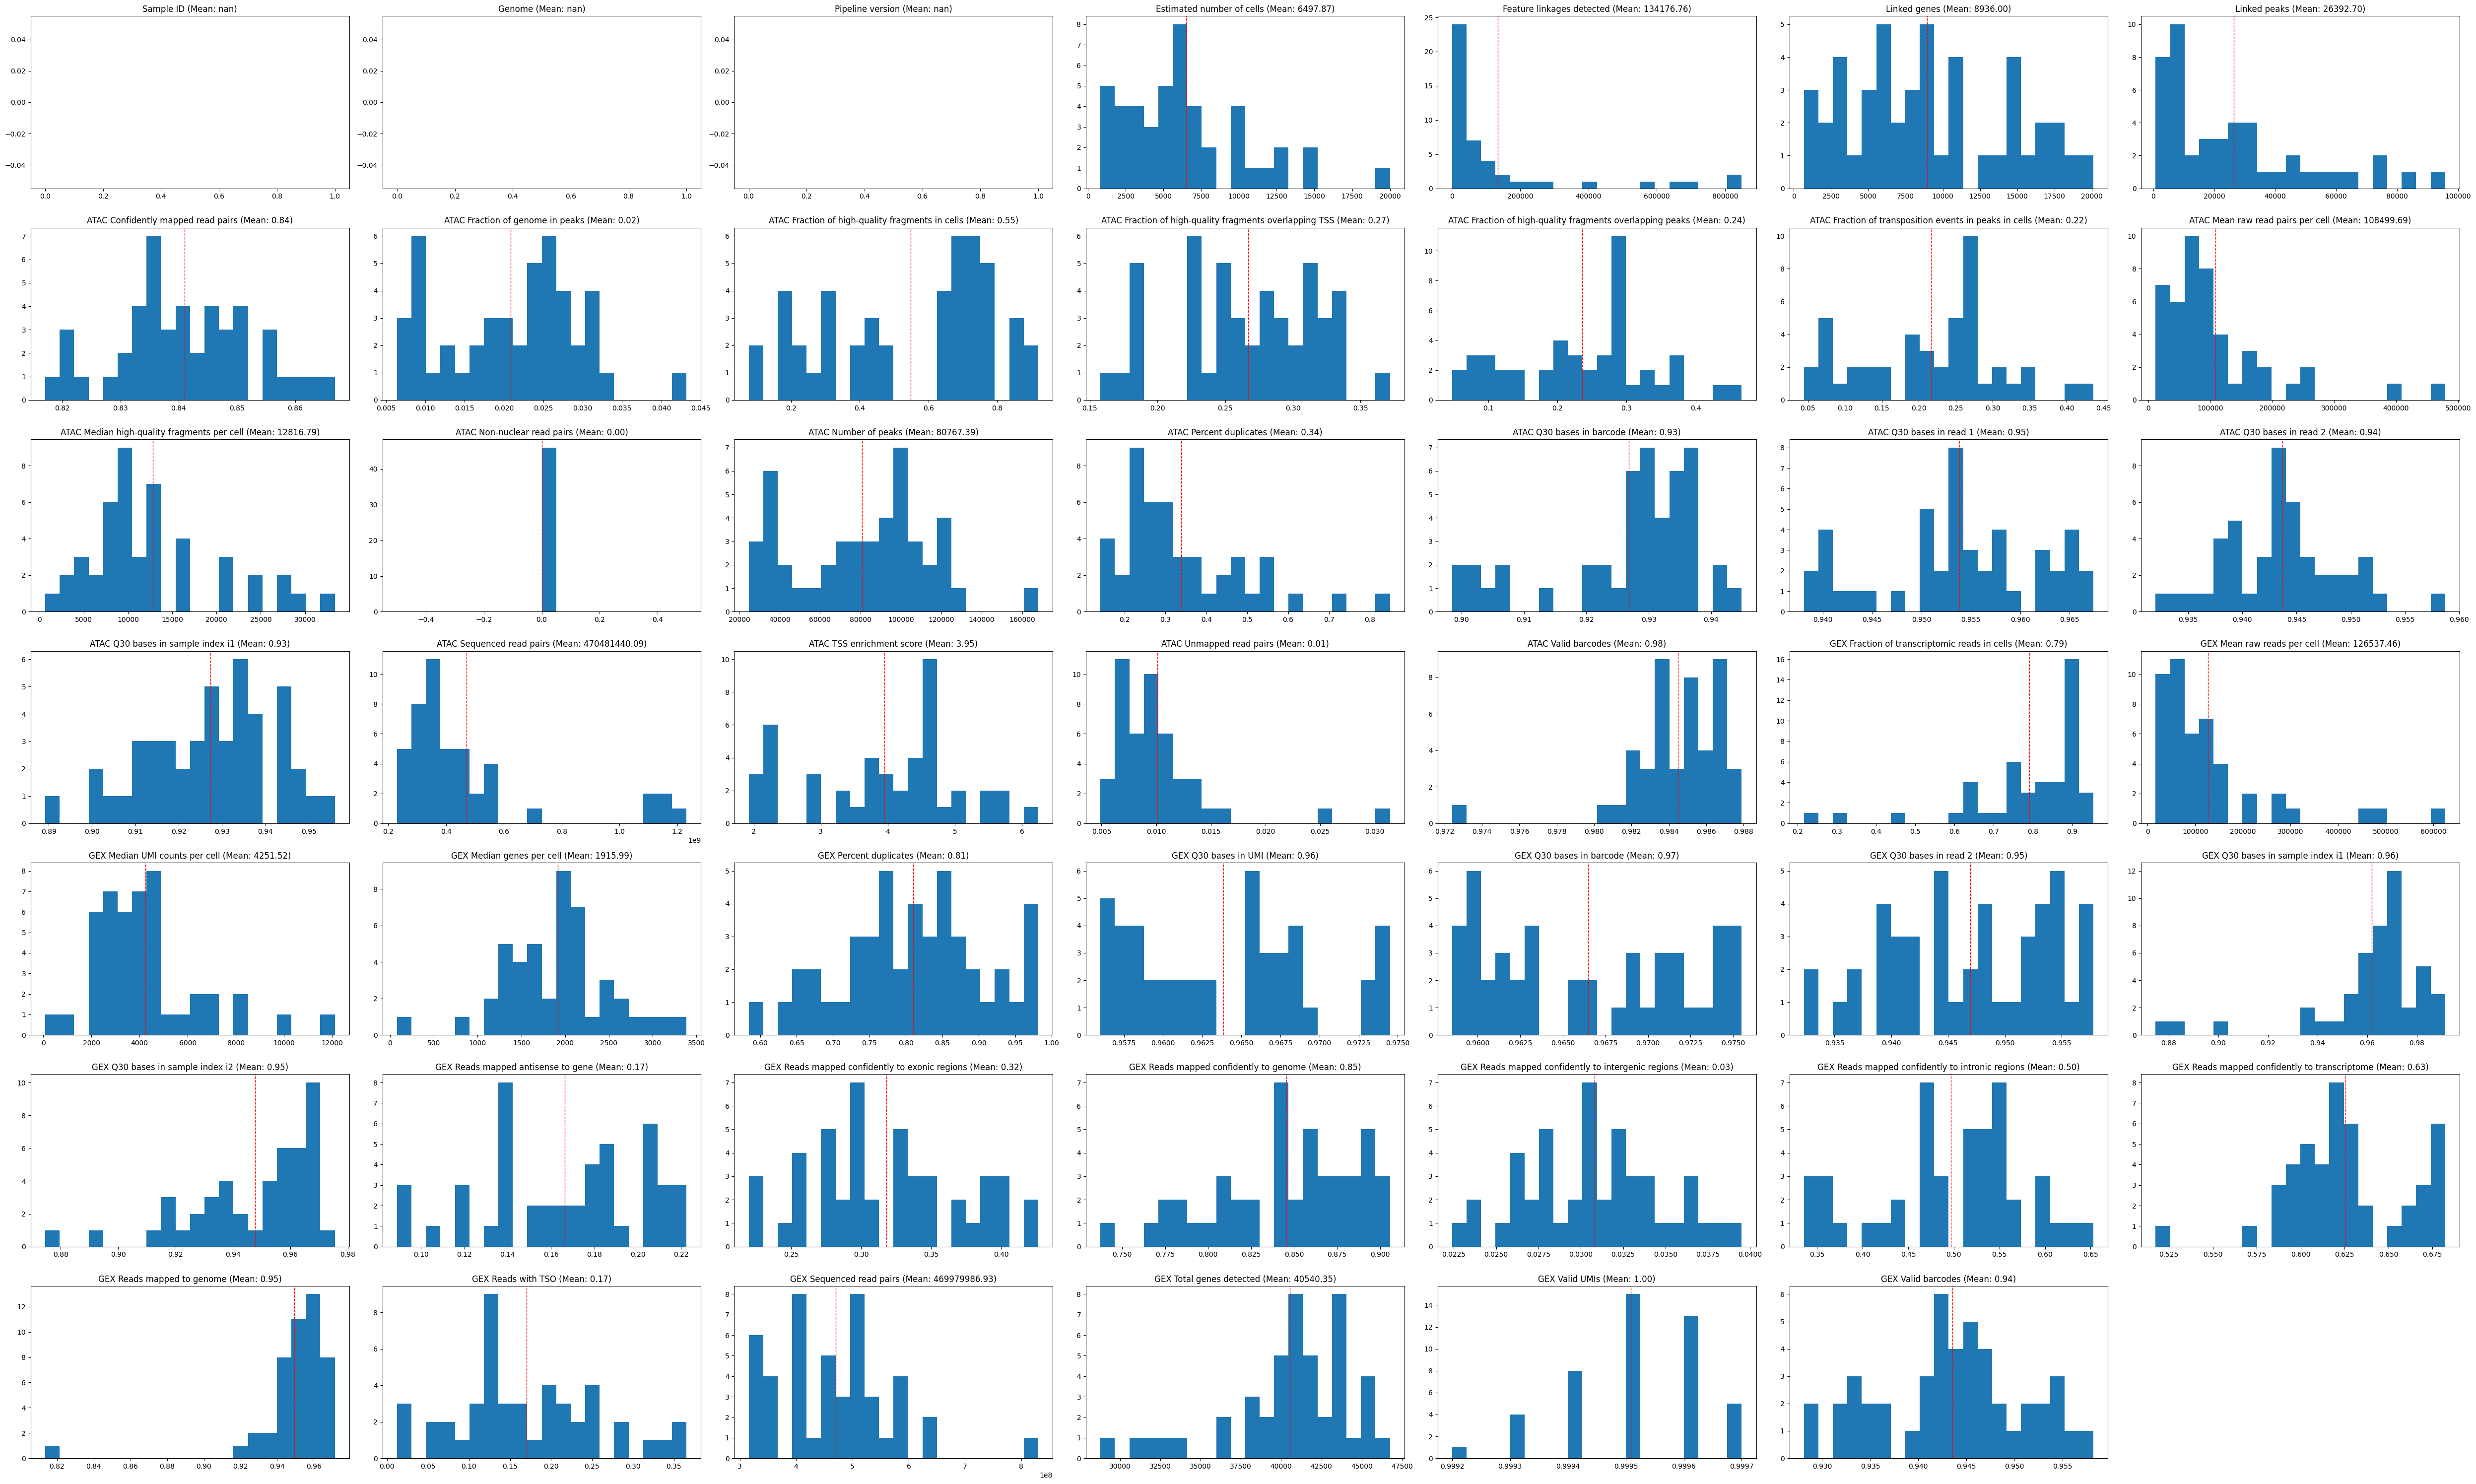

In [6]:
plot_histograms(mapping_summaries, metrics, bins=20)

## Creating mdata object

In [7]:
mapping_h5_slice = {sample: os.path.join(mapping_dir, sample, sample, 'outs/filtered_feature_bc_matrix.h5') for sample in samples[:20] if os.path.isfile(os.path.join(mapping_dir, sample, sample, 'outs/filtered_feature_bc_matrix.h5'))}
mapping_h5_slice

{'HCAHeart9508627_HCAHeart9508819': '../../../../backup/.data/mapping_py/HCAHeart9508627_HCAHeart9508819/HCAHeart9508627_HCAHeart9508819/outs/filtered_feature_bc_matrix.h5',
 'HCAHeart9508628_HCAHeart9508820': '../../../../backup/.data/mapping_py/HCAHeart9508628_HCAHeart9508820/HCAHeart9508628_HCAHeart9508820/outs/filtered_feature_bc_matrix.h5',
 'HCAHeart9508629_HCAHeart9508821': '../../../../backup/.data/mapping_py/HCAHeart9508629_HCAHeart9508821/HCAHeart9508629_HCAHeart9508821/outs/filtered_feature_bc_matrix.h5',
 'HCAHeart9845431_HCAHeart9917173': '../../../../backup/.data/mapping_py/HCAHeart9845431_HCAHeart9917173/HCAHeart9845431_HCAHeart9917173/outs/filtered_feature_bc_matrix.h5',
 'HCAHeart9845432_HCAHeart9917174': '../../../../backup/.data/mapping_py/HCAHeart9845432_HCAHeart9917174/HCAHeart9845432_HCAHeart9917174/outs/filtered_feature_bc_matrix.h5',
 'HCAHeart9845433_HCAHeart9917175': '../../../../backup/.data/mapping_py/HCAHeart9845433_HCAHeart9917175/HCAHeart9845433_HCAHeart9

In [8]:
adatas_rna = {}
adatas_atac = {}

for sample_id, filepath in mapping_h5.items():
    sample_adata_rna = sc.read_10x_h5(filepath)
    sample_adata_rna.var_names_make_unique()
    adatas_rna[sample_id] = sample_adata_rna
    sample_adata_atac = ac.read_10x_h5(filepath)
    sample_adata_atac.var_names_make_unique()
    adatas_atac[sample_id] = sample_adata_atac

adata_rna = sc.concat(adatas_rna, label="sample")
del adatas_rna
adata_rna.obs_names_make_unique()
adata_atac = sc.concat(adatas_atac, label="sample", join='outer')
del adatas_atac
adata_atac.obs_names_make_unique()
mdata = mu.MuData(
    {
        'rna': adata_rna,
        'atac': adata_atac,
    }
)
del adata_rna
del adata_atac
mdata

/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.10/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(
/home/ceger/miniforge3/envs/heart_mapping/lib/python3.

MuData object with n_obs × n_vars = 298902 × 3775615
  2 modalities
    rna:	298902 x 70711
      obs:	'sample'
    atac:	298902 x 3704904
      obs:	'sample'

In [9]:
mdata.write('.data/E-MTAB12916_E-MTAB12919.h5mu')

In [10]:
mdata.obs

,rna:sample,atac:sample
AAACATGCAGCAGGTA-1,HCAHeart9508627_HCAHeart9508819,HCAHeart9508627_HCAHeart9508819
AAACATGCATAGCTGC-1,HCAHeart9508627_HCAHeart9508819,HCAHeart9508627_HCAHeart9508819
AAACCAACAAGGTGCA-1,HCAHeart9508627_HCAHeart9508819,HCAHeart9508627_HCAHeart9508819
AAACCAACACTTAACG-1,HCAHeart9508627_HCAHeart9508819,HCAHeart9508627_HCAHeart9508819
AAACCAACAGCCGCTA-1,HCAHeart9508627_HCAHeart9508819,HCAHeart9508627_HCAHeart9508819
...,...,...
TTTGTTGGTAGCAGCT-1,HCAHeartST13189997_HCAHeartST13188802,HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTCATTAGG-1,HCAHeartST13189997_HCAHeartST13188802,HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTGGTGAGA-1,HCAHeartST13189997_HCAHeartST13188802,HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTTGCATCT-1-1,HCAHeartST13189997_HCAHeartST13188802,HCAHeartST13189997_HCAHeartST13188802
